In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path
import tomllib
from loguru import logger
# --- Configuration ---
sns.set_theme(style="whitegrid", palette="muted")

In [3]:
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. Run src/preprocess.py first and check the timestamp!"
    )

df = pd.read_parquet(datafile)
df.columns

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

In [4]:
# --- Load metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={"index": "author"})
)

author_info_df.columns
# author_info_df.head()

Index(['author', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr', 'Floor_nr',
       'Nr_rooms', 'Board_function'],
      dtype='object')

In [5]:
# --- Merge WhatsApp data with user info ---
df_merged = df.merge(author_info_df, on="author", how="left")

# --- Step 0: Exclude Board_function == "none" ---
df_merged = df_merged[df_merged["Board_function"].str.lower() != "none"]


# logger.info(f"Merged dataset has {len(df_merged)} messages from {df_merged['author'].nunique()} authors.")
print(f"Merged dataset has {len(df_merged)} messages from {df_merged['author'].nunique()} authors.")

df_merged.columns

Merged dataset has 1683 messages from 13 authors.


Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length', 'Name', 'Gender', 'Entrance_nr', 'Unit_nr',
       'Floor_nr', 'Nr_rooms', 'Board_function'],
      dtype='object')

In [14]:
# --- Step 1: Count emojis per author ---
emoji_by_author = (
    df_merged.groupby(["Board_function", "author"])["has_emoji"]
    .sum()  # counts True values
    .reset_index()
    .rename(columns={"has_emoji": "emoji_count"})
)

# emoji_by_author.info()

In [15]:
# --- Step 2: Get the top author per Board_function ---
top_author_per_function = (
    emoji_by_author.loc[emoji_by_author.groupby("Board_function")["emoji_count"].idxmax()]
    .reset_index(drop=True)
)
top_author_per_function.head()
# top_author_per_function.info()

,Board_function,author,emoji_count
0,Algemeen bestuurslid,cackling-eland,26
1,Commissielid,vivid-rhinoceros,101
2,Penningmeester,cheerful-boar,7
3,Secretaris,peppy-rat,19
4,Voorzitter,intense-toad,42


In [16]:
# --- Step 3: Create emoji_by_board_function summary ---
emoji_by_board_function = top_author_per_function.sort_values(
    "emoji_count", ascending=False
)
emoji_by_board_function.head()

,Board_function,author,emoji_count
1,Commissielid,vivid-rhinoceros,101
4,Voorzitter,intense-toad,42
0,Algemeen bestuurslid,cackling-eland,26
3,Secretaris,peppy-rat,19
2,Penningmeester,cheerful-boar,7


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_2711/3019653708.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


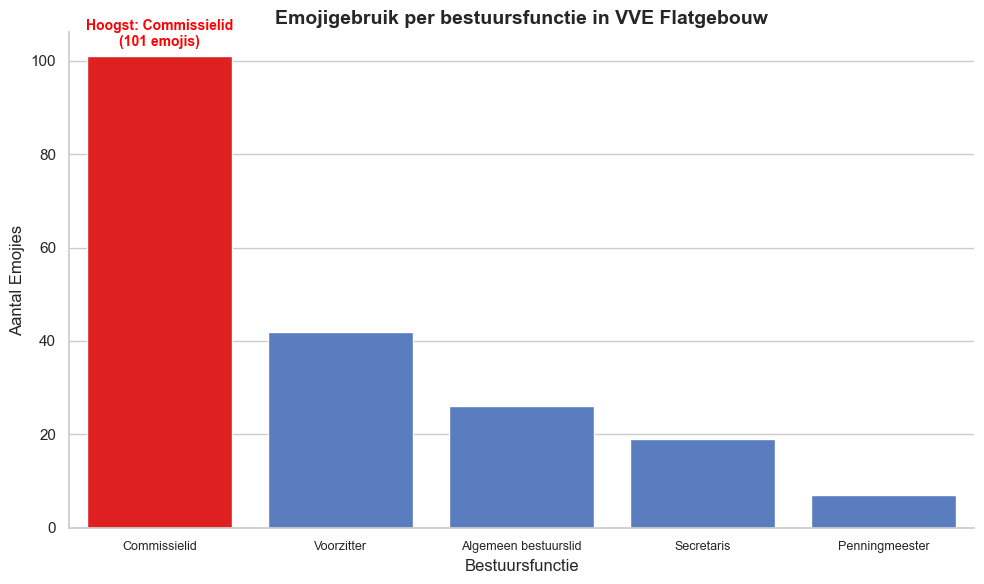

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Find the max emoji count and assign colors ---
max_idx = emoji_by_board_function["emoji_count"].idxmax()
max_function = emoji_by_board_function.loc[max_idx, "Board_function"]
max_value = emoji_by_board_function.loc[max_idx, "emoji_count"]

colors = [
    "red" if bf == max_function else sns.color_palette("muted")[0]
    for bf in emoji_by_board_function["Board_function"]
]

# --- Plot ---
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=emoji_by_board_function,
    x="Board_function",
    y="emoji_count",
    palette=colors
)

# --- Annotate the highest bar ---
bar = barplot.patches[list(emoji_by_board_function["Board_function"]).index(max_function)]
barplot.annotate(
    f"Hoogst: {max_function}\n({max_value} emojis)",
    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold",
    color="red",
    xytext=(0, 5),
    textcoords="offset points"
)

# --- Labels & title ---
plt.title("Emojigebruik per bestuursfunctie in VVE Flatgebouw", fontsize=14, fontweight="bold")
plt.xlabel("Bestuursfunctie", fontsize=12)
plt.ylabel("Aantal Emojies", fontsize=12)

# 🔤 Make x-axis labels smaller and horizontal
plt.xticks(fontsize=9, rotation=0, ha="center")

sns.despine()
plt.tight_layout()
plt.show()
